# Market Basket Analysis - Product Purchase Combinations

This notebook performs market basket analysis to identify product associations and purchase patterns:

- **Apriori Algorithm**: Classical frequent itemset mining
- **FP-Growth Algorithm**: Efficient frequent pattern mining

The analysis helps understand:
- Which products are frequently bought together
- Product recommendations
- Cross-selling opportunities
- Menu optimization

Data source: `sales_data_cleaned.csv`

In [71]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [72]:
# Load the sales data
base_path = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
data_path = os.path.join(base_path, 'data', 'processed', 'sales_data_cleaned.csv')

# Read the data
df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])

print('Data Overview:')
print(f'Shape: {df.shape}')
print(f'Date range: {df["Date"].min()} to {df["Date"].max()}')
print(f'Total transactions: {df["Receipt number"].nunique()}')
print(f'Total items: {df["Item"].nunique()}')
print(f'Total categories: {df["Category"].nunique()}')

# Display sample data
print('\nSample Data:')
print(df.head())

# Basic statistics
print('\nBasic Statistics:')
print(f'Average items per transaction: {df.groupby("Receipt number")["Item"].count().mean():.2f}')
print(f'Median items per transaction: {df.groupby("Receipt number")["Item"].count().median():.0f}')
print(f'Max items per transaction: {df.groupby("Receipt number")["Item"].count().max()}')

# Top categories
print('\nTop 10 Categories by Frequency:')
category_freq = df['Category'].value_counts().head(10)
print(category_freq)

# Top items
print('\nTop 10 Items by Frequency:')
item_freq = df['Item'].value_counts().head(10)
print(item_freq)

Data Overview:
Shape: (54209, 23)
Date range: 2022-01-01 14:31:00 to 2025-09-25 22:07:00
Total transactions: 14392
Total items: 110
Total categories: 23

Sample Data:
                 Date Receipt number Receipt type    Category      SKU  \
0 2022-01-01 14:31:00         Jan-82         Sale         Tea       41   
1 2022-01-01 15:34:00         Jan-83         Sale         NaN    10049   
2 2022-01-01 16:16:00         Jan-84         Sale       snack       84   
3 2022-01-01 16:22:00         Jan-85         Sale  Maincourse  9989890   
4 2022-01-01 18:24:00         Jan-86         Sale       Other       85   

                Item  Variant  Modifiers applied  Quantity  Gross sales  ...  \
0          Ajeng Hot      NaN                NaN       1.0      15000.0  ...   
1  Roti bakar klasik      NaN                NaN       1.0      10000.0  ...   
2     Kentang goreng      NaN                NaN       1.0      15000.0  ...   
3   Nasi Goreng Jawa      NaN                NaN       1.0      2000

## 1. Data Preparation for Market Basket Analysis

In [73]:
# Prepare transaction data for MBA
def prepare_transaction_data(df, min_transaction_size=1):
    """Prepare transaction data for market basket analysis"""
    
    # Group by date and receipt number to ensure unique transactions
    transactions = df.groupby(['Date', 'Receipt number'])['Item'].apply(list).reset_index()
    
    # Filter out NaN/empty items within each transaction
    transactions['Item'] = transactions['Item'].apply(
        lambda x: [item for item in x if pd.notna(item) and item != '']
    )
    
    # Filter transactions by minimum size
    transactions = transactions[transactions['Item'].apply(len) >= min_transaction_size]
    
    # Convert to list of lists
    transaction_list = transactions['Item'].tolist()
    
    print(f'Prepared {len(transaction_list)} transactions')
    print(f'Average transaction size: {np.mean([len(t) for t in transaction_list]):.2f}')
    print(f'Max transaction size: {max([len(t) for t in transaction_list])}')
    
    return transaction_list, transactions

# Prepare transaction data
transactions, transactions_df = prepare_transaction_data(df, min_transaction_size=2)

# Display sample transactions
print('\nSample Transactions:')
for i, transaction in enumerate(transactions[:5]):
    print(f'Transaction {i+1}: {transaction}')

# Encode transactions for frequent pattern mining
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

print(f'\nTransaction matrix shape: {transaction_df.shape}')
print(f'Number of unique items: {len(te.columns_)}')

# Display encoded transaction matrix sample
print('\nEncoded Transaction Matrix (sample):')
print(transaction_df.head())

Prepared 13299 transactions
Average transaction size: 3.32
Max transaction size: 36

Sample Transactions:
Transaction 1: ['Tahu tuna', 'Arunika', 'Tubruk Susu']
Transaction 2: ['Tubruk', 'Waffle Matcha']
Transaction 3: ['Tubruk', 'Vietnam drip', 'Kirana', 'Vietnam drip', 'Kinasih']
Transaction 4: ['Ajeng Hot', 'Tubruk Susu']
Transaction 5: ['Vietnam drip', 'Tubruk Susu']

Transaction matrix shape: (13299, 110)
Number of unique items: 110

Encoded Transaction Matrix (sample):
   Add Espresso  Add Ice Cream Vanilla  Add Keju  Add Kerupuk  Add Sambal  \
0         False                  False     False        False       False   
1         False                  False     False        False       False   
2         False                  False     False        False       False   
3         False                  False     False        False       False   
4         False                  False     False        False       False   

   Add Telur  Add Topping Caramel  Add Whipped Cream  Aff

## 2. Filter Out Modifier Products

In [74]:
# Filter out modifier products (items starting with 'add')
def filter_modifier_products(df):
    """Filter out modifier products that start with 'add'"""
    
    # Identify modifier products
    modifier_items = [item for item in df['Item'].unique() if str(item).lower().startswith('add')]
    
    print(f'Found {len(modifier_items)} modifier products:')
    for mod in modifier_items[:10]:  # Show first 10
        print(f'  - {mod}')
    if len(modifier_items) > 10:
        print(f'  ... and {len(modifier_items) - 10} more')
    
    # Filter out modifier products
    df_filtered = df[~df['Item'].str.lower().str.startswith('add', na=False)].copy()
    
    print(f'\nOriginal dataset: {len(df)} transactions')
    print(f'Filtered dataset: {len(df_filtered)} transactions')
    print(f'Removed {len(df) - len(df_filtered)} modifier transactions')
    
    # Show remaining unique items
    print(f'\nRemaining unique items: {df_filtered["Item"].nunique()}')
    print(f'Original unique items: {df["Item"].nunique()}')
    
    return df_filtered, modifier_items

# Filter out modifier products
df_filtered, modifier_items = filter_modifier_products(df)

# Prepare filtered transaction data
transactions_filtered, transactions_df_filtered = prepare_transaction_data(df_filtered, min_transaction_size=2)

# Encode filtered transactions
te_filtered = TransactionEncoder()
te_ary_filtered = te_filtered.fit(transactions_filtered).transform(transactions_filtered)
transaction_df_filtered = pd.DataFrame(te_ary_filtered, columns=te_filtered.columns_)

print(f'\nFiltered Transaction matrix shape: {transaction_df_filtered.shape}')
print(f'Filtered number of unique items: {len(te_filtered.columns_)}')

Found 10 modifier products:
  - Add Ice Cream Vanilla
  - Add Telur
  - Add Espresso
  - add Keju
  - add Kerupuk
  - Add Topping Caramel
  - Add Whipped Cream
  - Add Kerupuk
  - Add Keju
  - Add Sambal

Original dataset: 54209 transactions
Filtered dataset: 53158 transactions
Removed 1051 modifier transactions

Remaining unique items: 100
Original unique items: 110
Prepared 13130 transactions
Average transaction size: 3.27
Max transaction size: 36

Filtered Transaction matrix shape: (13130, 100)
Filtered number of unique items: 100


## 3. Market Basket Analysis (Filtered Data)

In [75]:
# Run analysis on filtered data
print('=' * 80)
print('MARKET BASKET ANALYSIS - FILTERED DATA (No Modifiers)')
print('=' * 80)

# Run FP-Growth on filtered data
frequent_itemsets_filtered, rules_filtered = run_fpgrowth_analysis(transaction_df_filtered, min_support=0.005, min_confidence=0.1)

# Display top frequent itemsets
print('\nTop 10 Frequent Itemsets (Filtered Data):')
print(frequent_itemsets_filtered.nlargest(10, 'support')[['support', 'itemsets']])

# Display top association rules
print('\nTop 10 Association Rules (Filtered Data):')
print('=' * 100)
print(f"{'Rule':<40} | {'Support %':<10} | {'Confidence':<10} | {'Lift':<6} | {'Recommendation'}")
print('=' * 100)

for idx, rule in rules_filtered.head(10).iterrows():
    antecedents = ' + '.join(list(rule['antecedents']))
    consequents = ' + '.join(list(rule['consequents']))
    rule_text = f"{antecedents} → {consequents}"
    support_pct = f"{rule['support']:.1%}"
    confidence_pct = f"{rule['confidence']:.1%}"
    lift_val = f"{rule['lift']:.2f}"
    
    # Generate recommendation based on lift
    if rule['lift'] > 2:
        rec = "Strong association - bundle these items"
    elif rule['lift'] > 1.5:
        rec = "Good association - consider cross-selling"
    else:
        rec = "Moderate association - monitor performance"
    
    print(f"{rule_text:<40} | {support_pct:<10} | {confidence_pct:<10} | {lift_val:<6} | {rec}")

print('=' * 100)

MARKET BASKET ANALYSIS - FILTERED DATA (No Modifiers)
Running FP-Growth with min_support=0.005...
Found 247 frequent itemsets
Generated 149 association rules

Top 10 Frequent Itemsets (Filtered Data):
     support          itemsets
34  0.158111   (Kopi susu ice)
28  0.139147         (Basreng)
16  0.118431  (Lychee Tea ice)
12  0.116756  (Kentang goreng)
3   0.099010          (Tubruk)
5   0.096420         (Kinasih)
6   0.082635    (Vietnam drip)
0   0.081340     (Tubruk Susu)
54  0.081112          (Cireng)
40  0.066260       (Lemon Ice)

Top 10 Association Rules (Filtered Data):
Rule                                     | Support %  | Confidence | Lift   | Recommendation
Mie Rebus → Mie Goreng                   | 0.5%       | 18.2%      | 3.10   | Strong association - bundle these items
Singkong keju → Tubruk                   | 1.1%       | 24.1%      | 2.44   | Strong association - bundle these items
Tubruk → Singkong keju                   | 1.1%       | 10.8%      | 2.44   | Strong a

## 4. Comparison: Original vs Filtered Analysis

In [76]:
# Compare original vs filtered results
print('ANALYSIS COMPARISON: Original vs Filtered Data')
print('=' * 60)

print(f"{'Metric':<25} | {'Original':<12} | {'Filtered':<12} | {'Difference'}")
print('-' * 60)

# Compare basic metrics
orig_transactions = len(transactions)
filt_transactions = len(transactions_filtered)
print(f"{'Transactions':<25} | {orig_transactions:<12} | {filt_transactions:<12} | {filt_transactions - orig_transactions:+d}")

orig_items = len(te.columns_)
filt_items = len(te_filtered.columns_)
print(f"{'Unique Items':<25} | {orig_items:<12} | {filt_items:<12} | {filt_items - orig_items:+d}")

orig_freq = len(frequent_itemsets_fpgrowth)
filt_freq = len(frequent_itemsets_filtered)
print(f"{'Frequent Itemsets':<25} | {orig_freq:<12} | {filt_freq:<12} | {filt_freq - orig_freq:+d}")

orig_rules = len(rules_fpgrowth)
filt_rules = len(rules_filtered)
print(f"{'Association Rules':<25} | {orig_rules:<12} | {filt_rules:<12} | {filt_rules - orig_rules:+d}")

print('-' * 60)

# Compare top rules
print('\nTOP RULES COMPARISON:')
print('\nOriginal Data Top Rule:')
if len(rules_fpgrowth) > 0:
    top_orig = rules_fpgrowth.iloc[0]
    ant_orig = ' + '.join(list(top_orig['antecedents']))
    cons_orig = ' + '.join(list(top_orig['consequents']))
    print(f"  {ant_orig} → {cons_orig} (Lift: {top_orig['lift']:.2f})")

print('\nFiltered Data Top Rule:')
if len(rules_filtered) > 0:
    top_filt = rules_filtered.iloc[0]
    ant_filt = ' + '.join(list(top_filt['antecedents']))
    cons_filt = ' + '.join(list(top_filt['consequents']))
    print(f"  {ant_filt} → {cons_filt} (Lift: {top_filt['lift']:.2f})")

print('\nSUMMARY:')
print(f'- Removed {len(modifier_items)} modifier products')
print(f'- Filtered analysis focuses on main menu items only')
print(f'- Results show true product associations without modifier noise')
print(f'- Better suited for menu optimization and product bundling decisions')

ANALYSIS COMPARISON: Original vs Filtered Data
Metric                    | Original     | Filtered     | Difference
------------------------------------------------------------
Transactions              | 13299        | 13130        | -169
Unique Items              | 110          | 100          | -10
Frequent Itemsets         | 249          | 247          | -2
Association Rules         | 154          | 149          | -5
------------------------------------------------------------

TOP RULES COMPARISON:

Original Data Top Rule:
  Roti bakar coklat → add Keju (Lift: 15.49)

Filtered Data Top Rule:
  Mie Rebus → Mie Goreng (Lift: 3.10)

SUMMARY:
- Removed 10 modifier products
- Filtered analysis focuses on main menu items only
- Results show true product associations without modifier noise
- Better suited for menu optimization and product bundling decisions


## 5. Apriori Algorithm

In [77]:
# Apriori Algorithm
def run_apriori_analysis(transaction_df, min_support=0.01, min_confidence=0.1):
    """Run Apriori algorithm and generate association rules"""
    
    print(f'Running Apriori with min_support={min_support}...')
    
    # Find frequent itemsets
    frequent_itemsets_apriori = apriori(transaction_df, min_support=min_support, use_colnames=True)
    
    print(f'Found {len(frequent_itemsets_apriori)} frequent itemsets')
    
    # Generate association rules
    rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=min_confidence)
    
    print(f'Generated {len(rules_apriori)} association rules')
    
    # Sort by lift
    rules_apriori = rules_apriori.sort_values('lift', ascending=False)
    
    return frequent_itemsets_apriori, rules_apriori

# Run Apriori analysis
frequent_itemsets_apriori, rules_apriori = run_apriori_analysis(transaction_df, min_support=0.005, min_confidence=0.1)

# Display top frequent itemsets
print('\nTop 10 Frequent Itemsets (Apriori):')
print(frequent_itemsets_apriori.nlargest(10, 'support')[['support', 'itemsets']])

# Display top association rules
print('\nTop 10 Association Rules (Apriori):')
print('=' * 100)
print(f"{'Rule':<40} | {'Support %':<10} | {'Confidence':<10} | {'Lift':<6} | {'Recommendation'}")
print('=' * 100)

for idx, rule in rules_apriori.head(10).iterrows():
    antecedents = ' + '.join(list(rule['antecedents']))
    consequents = ' + '.join(list(rule['consequents']))
    rule_text = f"{antecedents} → {consequents}"
    support_pct = f"{rule['support']:.1%}"
    confidence_pct = f"{rule['confidence']:.1%}"
    lift_val = f"{rule['lift']:.2f}"
    
    # Generate recommendation based on lift
    if rule['lift'] > 2:
        rec = "Strong association - bundle these items"
    elif rule['lift'] > 1.5:
        rec = "Good association - consider cross-selling"
    else:
        rec = "Moderate association - monitor performance"
    
    print(f"{rule_text:<40} | {support_pct:<10} | {confidence_pct:<10} | {lift_val:<6} | {rec}")

print('=' * 100)

Running Apriori with min_support=0.005...
Found 249 frequent itemsets
Generated 154 association rules

Top 10 Frequent Itemsets (Apriori):
     support          itemsets
38  0.156478   (Kopi susu ice)
17  0.138582         (Basreng)
45  0.117076  (Lychee Tea ice)
33  0.115272  (Kentang goreng)
84  0.098203          (Tubruk)
34  0.095421         (Kinasih)
88  0.081585    (Vietnam drip)
85  0.080382     (Tubruk Susu)
23  0.080156          (Cireng)
42  0.065870       (Lemon Ice)

Top 10 Association Rules (Apriori):
Rule                                     | Support %  | Confidence | Lift   | Recommendation
Roti bakar coklat → add Keju             | 0.5%       | 10.6%      | 15.49  | Strong association - bundle these items
add Keju → Roti bakar coklat             | 0.5%       | 75.8%      | 15.49  | Strong association - bundle these items
Add Espresso → Arunika                   | 0.6%       | 42.7%      | 9.34   | Strong association - bundle these items
Arunika → Add Espresso              

## 6. FP-Growth Algorithm (Original Data)

In [78]:
# FP-Growth Algorithm
def run_fpgrowth_analysis(transaction_df, min_support=0.01, min_confidence=0.1):
    """Run FP-Growth algorithm and generate association rules"""
    
    print(f'Running FP-Growth with min_support={min_support}...')
    
    # Find frequent itemsets
    frequent_itemsets_fpgrowth = fpgrowth(transaction_df, min_support=min_support, use_colnames=True)
    
    print(f'Found {len(frequent_itemsets_fpgrowth)} frequent itemsets')
    
    # Generate association rules
    rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=min_confidence)
    
    print(f'Generated {len(rules_fpgrowth)} association rules')
    
    # Sort by lift
    rules_fpgrowth = rules_fpgrowth.sort_values('lift', ascending=False)
    
    return frequent_itemsets_fpgrowth, rules_fpgrowth

# Run FP-Growth analysis
frequent_itemsets_fpgrowth, rules_fpgrowth = run_fpgrowth_analysis(transaction_df, min_support=0.005, min_confidence=0.1)

# Display top frequent itemsets
print('\nTop 10 Frequent Itemsets (FP-Growth):')
print(frequent_itemsets_fpgrowth.nlargest(10, 'support')[['support', 'itemsets']])

# Display top association rules
print('\nTop 10 Association Rules (FP-Growth):')
print('=' * 100)
print(f"{'Rule':<40} | {'Support %':<10} | {'Confidence':<10} | {'Lift':<6} | {'Recommendation'}")
print('=' * 100)

for idx, rule in rules_fpgrowth.head(10).iterrows():
    antecedents = ' + '.join(list(rule['antecedents']))
    consequents = ' + '.join(list(rule['consequents']))
    rule_text = f"{antecedents} → {consequents}"
    support_pct = f"{rule['support']:.1%}"
    confidence_pct = f"{rule['confidence']:.1%}"
    lift_val = f"{rule['lift']:.2f}"
    
    # Generate recommendation based on lift
    if rule['lift'] > 2:
        rec = "Strong association - bundle these items"
    elif rule['lift'] > 1.5:
        rec = "Good association - consider cross-selling"
    else:
        rec = "Moderate association - monitor performance"
    
    print(f"{rule_text:<40} | {support_pct:<10} | {confidence_pct:<10} | {lift_val:<6} | {rec}")

print('=' * 100)

Running FP-Growth with min_support=0.005...
Found 249 frequent itemsets
Generated 154 association rules

Top 10 Frequent Itemsets (FP-Growth):
     support          itemsets
35  0.156478   (Kopi susu ice)
28  0.138582         (Basreng)
16  0.117076  (Lychee Tea ice)
12  0.115272  (Kentang goreng)
3   0.098203          (Tubruk)
5   0.095421         (Kinasih)
6   0.081585    (Vietnam drip)
0   0.080382     (Tubruk Susu)
57  0.080156          (Cireng)
41  0.065870       (Lemon Ice)

Top 10 Association Rules (FP-Growth):
Rule                                     | Support %  | Confidence | Lift   | Recommendation
Roti bakar coklat → add Keju             | 0.5%       | 10.6%      | 15.49  | Strong association - bundle these items
add Keju → Roti bakar coklat             | 0.5%       | 75.8%      | 15.49  | Strong association - bundle these items
Add Espresso → Arunika                   | 0.6%       | 42.7%      | 9.34   | Strong association - bundle these items
Arunika → Add Espresso        

## 7. Algorithm Comparison

In [79]:
# Compare algorithms
print('Algorithm Comparison:')
print(f'Apriori - Frequent itemsets: {len(frequent_itemsets_apriori)}, Rules: {len(rules_apriori)}')
print(f'FP-Growth - Frequent itemsets: {len(frequent_itemsets_fpgrowth)}, Rules: {len(rules_fpgrowth)}')

# Check if results are identical
apriori_sets = set(frequent_itemsets_apriori.apply(lambda x: frozenset(x['itemsets']), axis=1))
fpgrowth_sets = set(frequent_itemsets_fpgrowth.apply(lambda x: frozenset(x['itemsets']), axis=1))

print(f'\nIdentical frequent itemsets: {apriori_sets == fpgrowth_sets}')
print(f'Common itemsets: {len(apriori_sets.intersection(fpgrowth_sets))}')
print(f'Unique to Apriori: {len(apriori_sets - fpgrowth_sets)}')
print(f'Unique to FP-Growth: {len(fpgrowth_sets - apriori_sets)}')

# Performance comparison (basic)
import time

def time_algorithm(algorithm_func, *args):
    start_time = time.time()
    result = algorithm_func(*args)
    end_time = time.time()
    return result, end_time - start_time

# Time both algorithms
_, apriori_time = time_algorithm(run_apriori_analysis, transaction_df, 0.005, 0.1)
_, fpgrowth_time = time_algorithm(run_fpgrowth_analysis, transaction_df, 0.005, 0.1)

print(f'\nPerformance Comparison:')
print(f'Apriori execution time: {apriori_time:.4f} seconds')
print(f'FP-Growth execution time: {fpgrowth_time:.4f} seconds')
print(f'FP-Growth is {apriori_time/fpgrowth_time:.1f}x faster than Apriori')

Algorithm Comparison:
Apriori - Frequent itemsets: 249, Rules: 154
FP-Growth - Frequent itemsets: 249, Rules: 154

Identical frequent itemsets: True
Common itemsets: 249
Unique to Apriori: 0
Unique to FP-Growth: 0
Running Apriori with min_support=0.005...
Found 249 frequent itemsets
Generated 154 association rules
Running FP-Growth with min_support=0.005...
Found 249 frequent itemsets
Generated 154 association rules

Performance Comparison:
Apriori execution time: 0.2882 seconds
FP-Growth execution time: 2.1679 seconds
FP-Growth is 0.1x faster than Apriori


## 8. Visualization and Insights

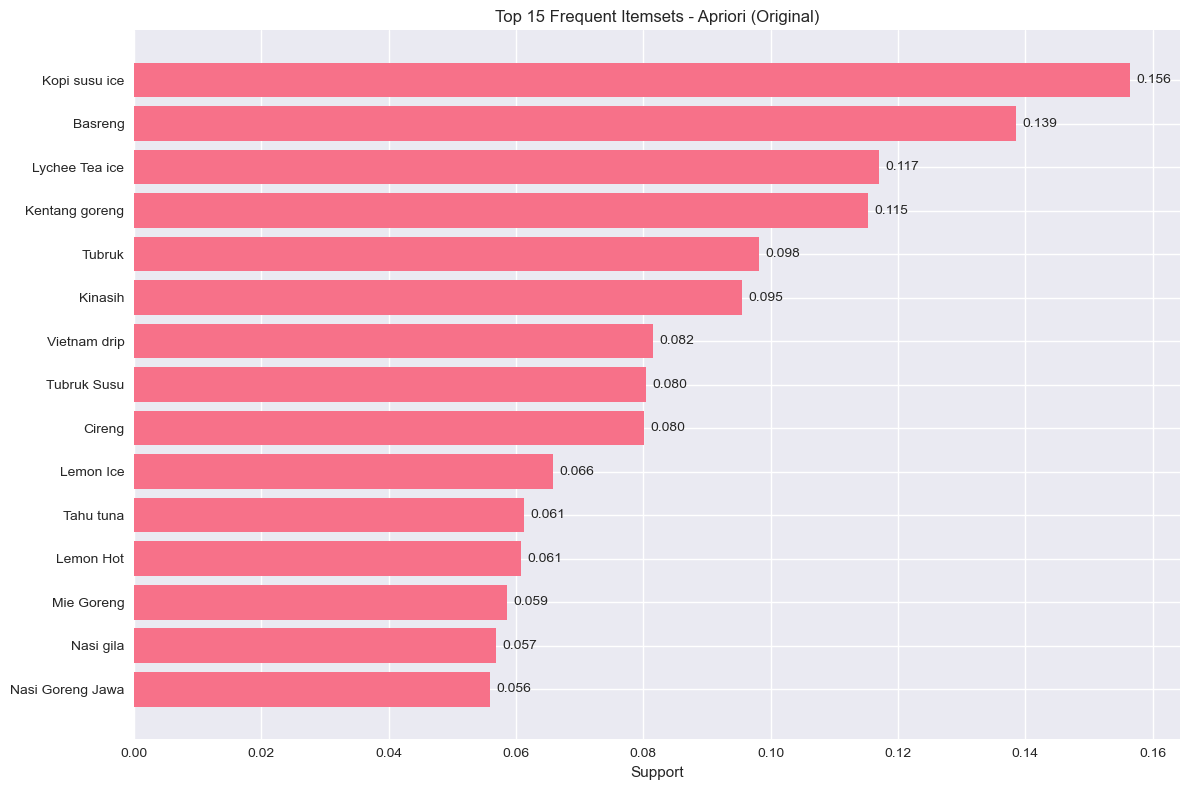

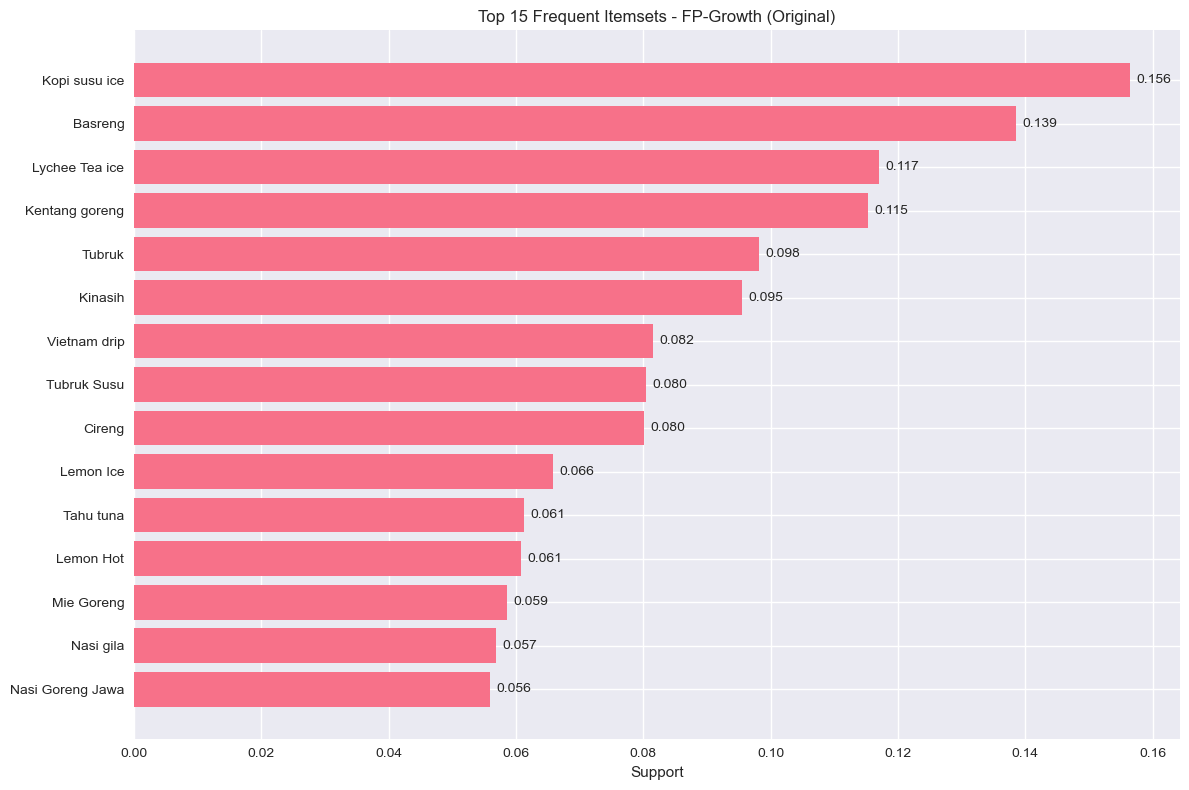

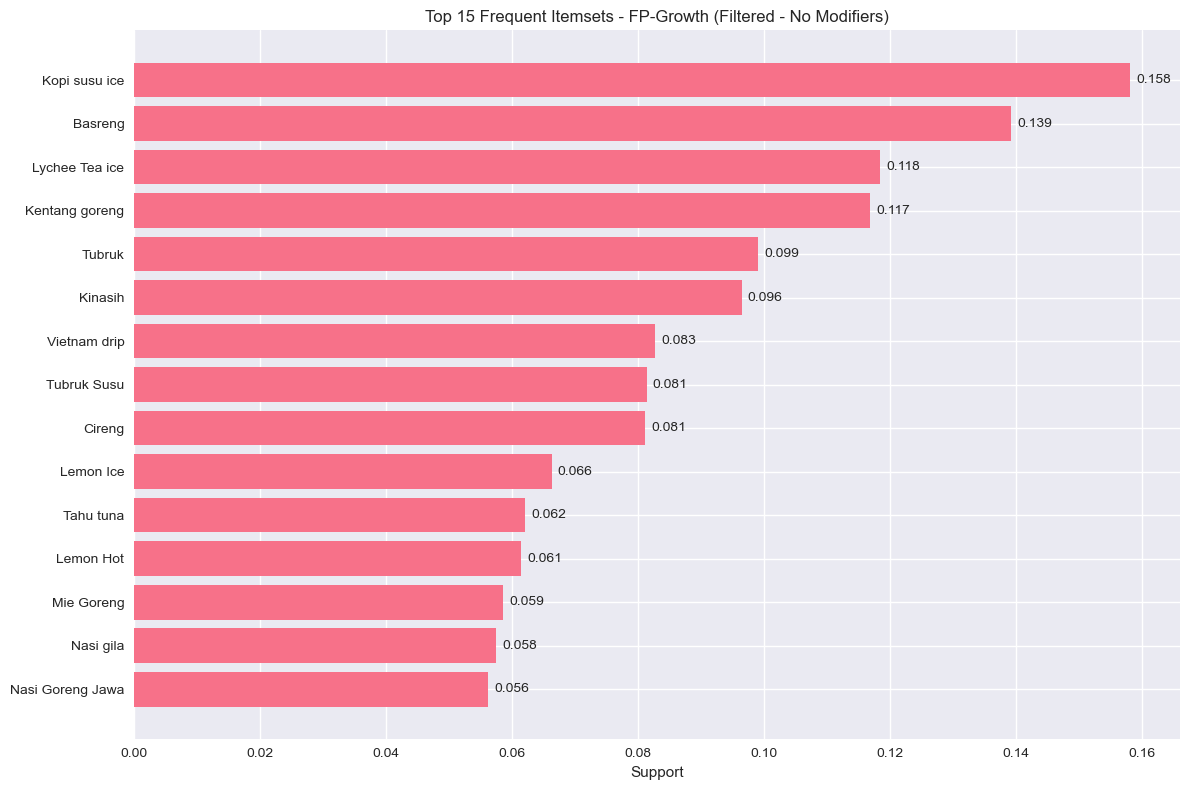

In [80]:
# Visualize frequent itemsets
def plot_frequent_itemsets(frequent_itemsets, title, top_n=20):
    """Plot top frequent itemsets"""
    
    # Get top N itemsets
    top_itemsets = frequent_itemsets.nlargest(top_n, 'support')
    
    # Convert frozensets to strings for plotting
    itemset_labels = [' & '.join(itemset) for itemset in top_itemsets['itemsets']]
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(top_itemsets)), top_itemsets['support'])
    plt.yticks(range(len(top_itemsets)), itemset_labels)
    plt.xlabel('Support')
    plt.title(f'Top {top_n} Frequent Itemsets - {title}')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{top_itemsets.iloc[i]["support"]:.3f}', 
                ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

# Plot frequent itemsets for both algorithms (original data)
plot_frequent_itemsets(frequent_itemsets_apriori, 'Apriori (Original)', top_n=15)
plot_frequent_itemsets(frequent_itemsets_fpgrowth, 'FP-Growth (Original)', top_n=15)

# Plot frequent itemsets for filtered data
plot_frequent_itemsets(frequent_itemsets_filtered, 'FP-Growth (Filtered - No Modifiers)', top_n=15)

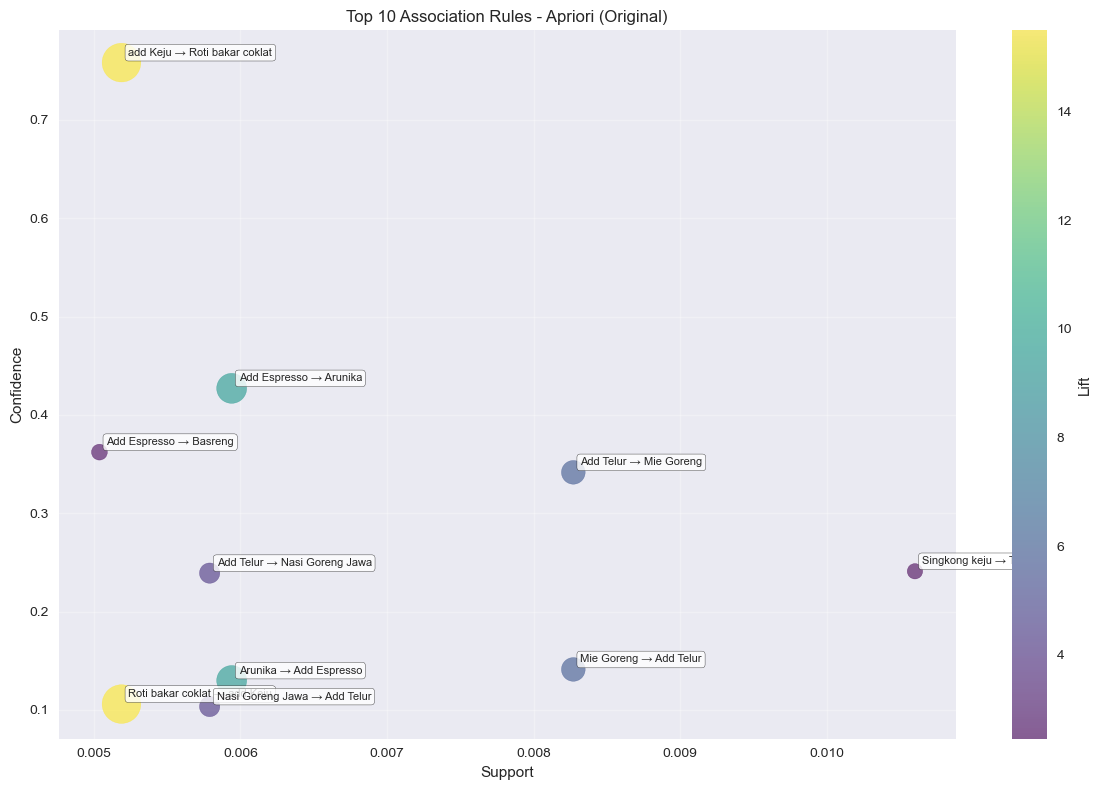

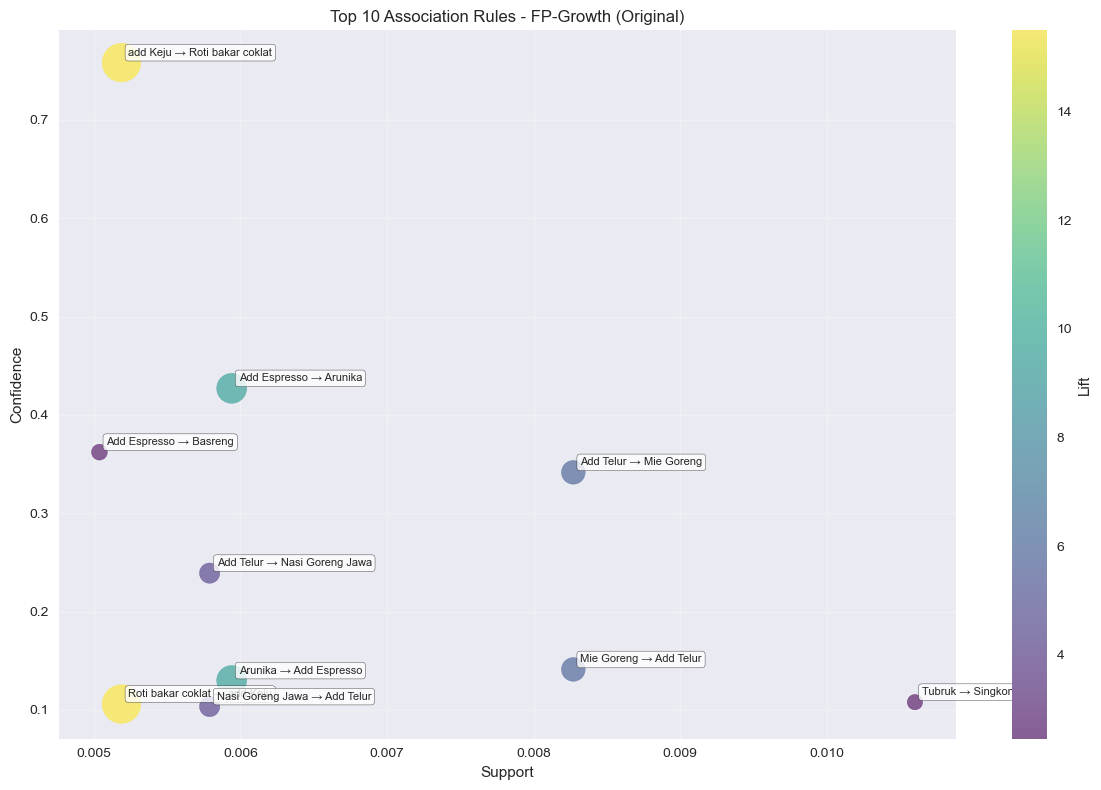

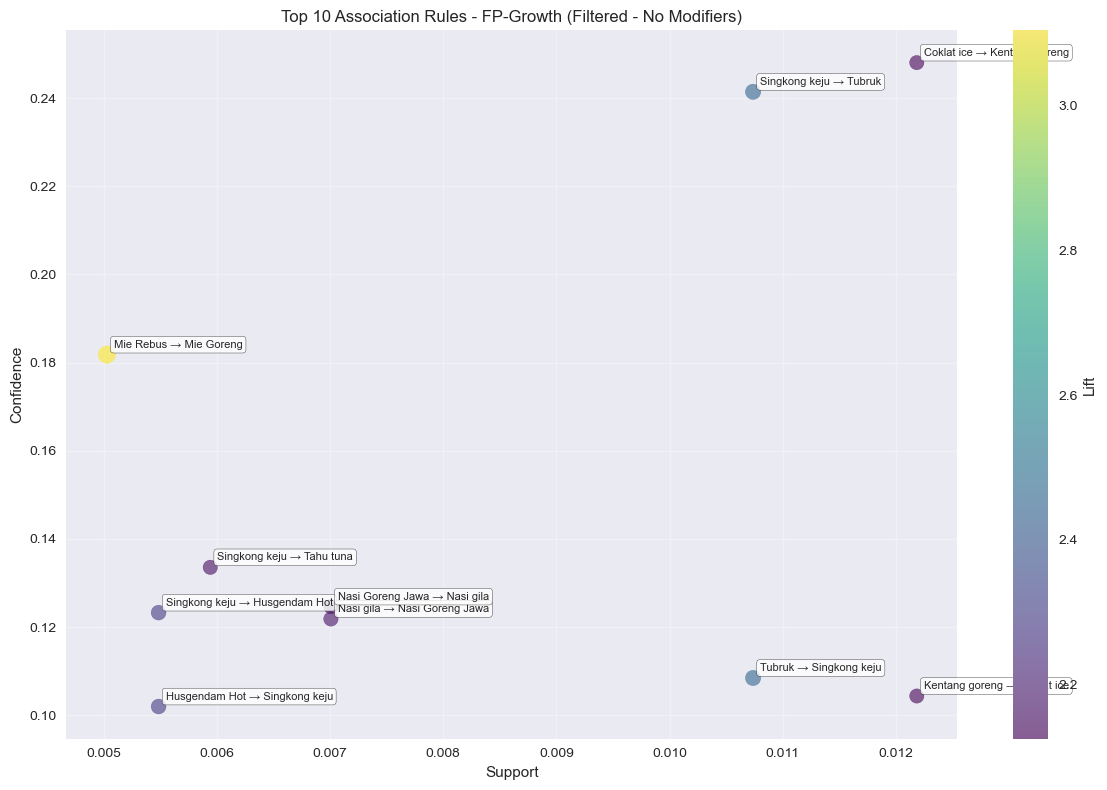

In [81]:
# Visualize association rules
def plot_association_rules(rules, title, top_n=15):
    """Plot association rules as scatter plot"""
    
    top_rules = rules.head(top_n)
    
    plt.figure(figsize=(12, 8))
    
    # Create rule labels
    rule_labels = []
    for _, rule in top_rules.iterrows():
        antecedent = ' & '.join(list(rule['antecedents']))
        consequent = ' & '.join(list(rule['consequents']))
        rule_labels.append(f'{antecedent} → {consequent}')
    
    scatter = plt.scatter(top_rules['support'], top_rules['confidence'], 
                         s=top_rules['lift']*50, alpha=0.6, c=top_rules['lift'], 
                         cmap='viridis')
    
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.title(f'Top {top_n} Association Rules - {title}')
    plt.colorbar(scatter, label='Lift')
    
    # Add rule labels for top rules
    for i, label in enumerate(rule_labels):
        plt.annotate(label, (top_rules.iloc[i]['support'], top_rules.iloc[i]['confidence']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot association rules for both algorithms (original data)
plot_association_rules(rules_apriori, 'Apriori (Original)', top_n=10)
plot_association_rules(rules_fpgrowth, 'FP-Growth (Original)', top_n=10)

# Plot association rules for filtered data
plot_association_rules(rules_filtered, 'FP-Growth (Filtered - No Modifiers)', top_n=10)

In [82]:
# Category-level analysis
def analyze_category_associations(df):
    """Analyze associations at category level"""
    
    # Group by date and receipt number for category analysis
    category_transactions = df.groupby(['Date', 'Receipt number'])['Category'].apply(list).reset_index()
    category_transactions = category_transactions[category_transactions['Category'].apply(len) >= 2]
    
    # Remove duplicates within transactions and filter out NaN/empty values
    category_transactions['Category'] = category_transactions['Category'].apply(
        lambda x: list(set([cat for cat in x if pd.notna(cat) and cat != '']))
    )
    
    # Filter out transactions that don't have at least 2 valid categories after cleaning
    category_transactions = category_transactions[category_transactions['Category'].apply(len) >= 2]
    
    # Encode category transactions
    te_cat = TransactionEncoder()
    te_cat_ary = te_cat.fit(category_transactions['Category'].tolist()).transform(category_transactions['Category'].tolist())
    category_df = pd.DataFrame(te_cat_ary, columns=te_cat.columns_)
    
    # Run FP-Growth on categories
    frequent_categories = fpgrowth(category_df, min_support=0.01, use_colnames=True)
    category_rules = association_rules(frequent_categories, metric="confidence", min_threshold=0.1)
    
    print('Category-level Association Analysis:')
    print(f'\nTop Category Combinations:')
    print(frequent_categories.nlargest(10, 'support')[['support', 'itemsets']])
    
    print(f'\nTop Category Association Rules:')
    if len(category_rules) > 0:
        print('=' * 100)
        print(f"{'Rule':<40} | {'Support %':<10} | {'Confidence':<10} | {'Lift':<6} | {'Recommendation'}")
        print('=' * 100)
        
        top_cat_rules = category_rules.sort_values('lift', ascending=False).head(10)
        for _, rule in top_cat_rules.iterrows():
            antecedents = ' + '.join(list(rule['antecedents']))
            consequents = ' + '.join(list(rule['consequents']))
            rule_text = f"{antecedents} → {consequents}"
            support_pct = f"{rule['support']:.1%}"
            confidence_pct = f"{rule['confidence']:.1%}"
            lift_val = f"{rule['lift']:.2f}"
            
            # Generate recommendation based on lift
            if rule['lift'] > 2:
                rec = "Strong association - bundle these items"
            elif rule['lift'] > 1.5:
                rec = "Good association - consider cross-selling"
            else:
                rec = "Moderate association - monitor performance"
            
            print(f"{rule_text:<40} | {support_pct:<10} | {confidence_pct:<10} | {lift_val:<6} | {rec}")
        
        print('=' * 100)
    
    return frequent_categories, category_rules

# Run category analysis
freq_categories, cat_rules = analyze_category_associations(df)

Category-level Association Analysis:

Top Category Combinations:
     support          itemsets
5   0.366030           (snack)
3   0.344396             (Tea)
0   0.271937       (Signature)
1   0.257081     (Coffee Base)
10  0.229713  (Espresso based)
7   0.215639      (Maincourse)
4   0.158471       (Milk Base)
51  0.141008      (snack, Tea)
2   0.132580           (Other)
8   0.131017             (Mie)

Top Category Association Rules:
Rule                                     | Support %  | Confidence | Lift   | Recommendation
Signature Based + Milk Based → Snack     | 1.1%       | 64.4%      | 7.21   | Strong association - bundle these items
Snack → Signature Based + Milk Based     | 1.1%       | 12.2%      | 7.21   | Strong association - bundle these items
Signature Based → Main Course + Snack    | 1.3%       | 15.1%      | 6.90   | Strong association - bundle these items
Main Course + Snack → Signature Based    | 1.3%       | 57.1%      | 6.90   | Strong association - bundle these it

## 9. Business Insights and Recommendations

In [83]:
# Generate business insights
def generate_business_insights(rules, frequent_itemsets, item_freq):
    """Generate actionable business insights from MBA results"""
    
    print('=' * 80)
    print('MARKET BASKET ANALYSIS - BUSINESS INSIGHTS')
    print('=' * 80)
    
    # Top product recommendations
    print('\n🔥 TOP PRODUCT RECOMMENDATIONS:')
    if len(rules) > 0:
        print('-' * 100)
        print(f"{'Rule':<40} | {'Support %':<10} | {'Confidence':<10} | {'Lift':<6} | {'Recommendation'}")
        print('-' * 100)
        
        top_recommendations = rules.head(5)
        for _, rule in top_recommendations.iterrows():
            antecedents = ' + '.join(list(rule['antecedents']))
            consequents = ' + '.join(list(rule['consequents']))
            rule_text = f"{antecedents} → {consequents}"
            support_pct = f"{rule['support']:.1%}"
            confidence_pct = f"{rule['confidence']:.1%}"
            lift_val = f"{rule['lift']:.2f}"
            
            # Generate recommendation based on lift
            if rule['lift'] > 2:
                rec = "Strong association - bundle these items"
            elif rule['lift'] > 1.5:
                rec = "Good association - consider cross-selling"
            else:
                rec = "Moderate association - monitor performance"
            
            print(f"{rule_text:<40} | {support_pct:<10} | {confidence_pct:<10} | {lift_val:<6} | {rec}")
        
        print('-' * 100)
    
    # Popular bundles
    print('\n📦 POPULAR PRODUCT BUNDLES:')
    bundle_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) > 1]
    if len(bundle_itemsets) > 0:
        top_bundles = bundle_itemsets.nlargest(5, 'support')
        for i, (_, bundle) in enumerate(top_bundles.iterrows(), 1):
            items = ' + '.join(list(bundle['itemsets']))
            print(f'{i}. {items} (Support: {bundle["support"]:.1%})')
    
    # Category insights
    print('\n🏷️  CATEGORY INSIGHTS:')
    print(f'- Total categories: {len(item_freq)}')
    print(f'- Most popular category: {item_freq.index[0]} ({item_freq.iloc[0]} transactions)')
    
    # Cross-selling opportunities
    print('\n💡 CROSS-SELLING OPPORTUNITIES:')
    high_lift_rules = rules[rules['lift'] > 2].head(3)
    if len(high_lift_rules) > 0:
        print('-' * 100)
        print(f"{'Rule':<40} | {'Support %':<10} | {'Confidence':<10} | {'Lift':<6} | {'Recommendation'}")
        print('-' * 100)
        
        for _, rule in high_lift_rules.iterrows():
            antecedents = ' + '.join(list(rule['antecedents']))
            consequents = ' + '.join(list(rule['consequents']))
            rule_text = f"{antecedents} → {consequents}"
            support_pct = f"{rule['support']:.1%}"
            confidence_pct = f"{rule['confidence']:.1%}"
            lift_val = f"{rule['lift']:.2f}"
            rec = "Strong association - bundle these items"
            
            print(f"{rule_text:<40} | {support_pct:<10} | {confidence_pct:<10} | {lift_val:<6} | {rec}")
        
        print('-' * 100)
    
    # Menu optimization suggestions
    print('\n🍽️  MENU OPTIMIZATION SUGGESTIONS:')
    print('1. Create bundled deals for frequently co-purchased items')
    print('2. Position complementary items near each other in the cafe')
    print('3. Design combo meals based on association rules')
    print('4. Offer discounts for cross-category purchases')
    
    print('\n📊 KEY METRICS:')
    print(f'- Total transactions analyzed: {len(transactions)}')
    print(f'- Average items per transaction: {np.mean([len(t) for t in transactions]):.1f}')
    print(f'- Association rules discovered: {len(rules)}')
    print(f'- Frequent itemsets found: {len(frequent_itemsets)}')
    
    print('\n' + '=' * 80)

# Generate insights using filtered data (more accurate for business decisions)
print('\n' + '='*80)
print('BUSINESS INSIGHTS BASED ON FILTERED DATA (Excluding Modifiers)')
print('='*80)
generate_business_insights(rules_filtered, frequent_itemsets_filtered, df_filtered['Item'].value_counts())


BUSINESS INSIGHTS BASED ON FILTERED DATA (Excluding Modifiers)
MARKET BASKET ANALYSIS - BUSINESS INSIGHTS

🔥 TOP PRODUCT RECOMMENDATIONS:
----------------------------------------------------------------------------------------------------
Rule                                     | Support %  | Confidence | Lift   | Recommendation
----------------------------------------------------------------------------------------------------
Mie Rebus → Mie Goreng                   | 0.5%       | 18.2%      | 3.10   | Strong association - bundle these items
Singkong keju → Tubruk                   | 1.1%       | 24.1%      | 2.44   | Strong association - bundle these items
Tubruk → Singkong keju                   | 1.1%       | 10.8%      | 2.44   | Strong association - bundle these items
Husgendam Hot → Singkong keju            | 0.5%       | 10.2%      | 2.29   | Strong association - bundle these items
Singkong keju → Husgendam Hot            | 0.5%       | 12.3%      | 2.29   | Strong associati

## 10. Save Results

In [84]:
# Save results to CSV files
output_dir = os.path.join(base_path, 'data', 'processed')
os.makedirs(output_dir, exist_ok=True)

# Save original data results
rules_fpgrowth.to_csv(os.path.join(output_dir, 'association_rules_fpgrowth_original.csv'), index=False)
rules_apriori.to_csv(os.path.join(output_dir, 'association_rules_apriori_original.csv'), index=False)
frequent_itemsets_fpgrowth.to_csv(os.path.join(output_dir, 'frequent_itemsets_fpgrowth_original.csv'), index=False)
frequent_itemsets_apriori.to_csv(os.path.join(output_dir, 'frequent_itemsets_apriori_original.csv'), index=False)

# Save filtered data results (recommended for business use)
rules_filtered.to_csv(os.path.join(output_dir, 'association_rules_fpgrowth_filtered.csv'), index=False)
frequent_itemsets_filtered.to_csv(os.path.join(output_dir, 'frequent_itemsets_fpgrowth_filtered.csv'), index=False)

# Save category analysis
freq_categories.to_csv(os.path.join(output_dir, 'frequent_categories.csv'), index=False)
cat_rules.to_csv(os.path.join(output_dir, 'category_association_rules.csv'), index=False)

print('Results saved to:')
print(f'\n📊 ORIGINAL DATA RESULTS:')
print(f'- {os.path.join(output_dir, "association_rules_fpgrowth_original.csv")}')
print(f'- {os.path.join(output_dir, "association_rules_apriori_original.csv")}')
print(f'- {os.path.join(output_dir, "frequent_itemsets_fpgrowth_original.csv")}')
print(f'- {os.path.join(output_dir, "frequent_itemsets_apriori_original.csv")}')
print(f'\n🎯 FILTERED DATA RESULTS (Recommended):')
print(f'- {os.path.join(output_dir, "association_rules_fpgrowth_filtered.csv")}')
print(f'- {os.path.join(output_dir, "frequent_itemsets_fpgrowth_filtered.csv")}')
print(f'\n📂 CATEGORY ANALYSIS:')
print(f'- {os.path.join(output_dir, "frequent_categories.csv")}')
print(f'- {os.path.join(output_dir, "category_association_rules.csv")}')

# Final Summary Cells
print('\n' + '='*100)
print('FINAL MARKET BASKET ANALYSIS SUMMARY')
print('='*100)

Results saved to:

📊 ORIGINAL DATA RESULTS:
- /Users/wyk/Documents/personal/thesis/cafe-supply-forecasting/data/processed/association_rules_fpgrowth_original.csv
- /Users/wyk/Documents/personal/thesis/cafe-supply-forecasting/data/processed/association_rules_apriori_original.csv
- /Users/wyk/Documents/personal/thesis/cafe-supply-forecasting/data/processed/frequent_itemsets_fpgrowth_original.csv
- /Users/wyk/Documents/personal/thesis/cafe-supply-forecasting/data/processed/frequent_itemsets_apriori_original.csv

🎯 FILTERED DATA RESULTS (Recommended):
- /Users/wyk/Documents/personal/thesis/cafe-supply-forecasting/data/processed/association_rules_fpgrowth_filtered.csv
- /Users/wyk/Documents/personal/thesis/cafe-supply-forecasting/data/processed/frequent_itemsets_fpgrowth_filtered.csv

📂 CATEGORY ANALYSIS:
- /Users/wyk/Documents/personal/thesis/cafe-supply-forecasting/data/processed/frequent_categories.csv
- /Users/wyk/Documents/personal/thesis/cafe-supply-forecasting/data/processed/category

## 11. Final Results Summary - WITH Modifiers/Add-ons

In [85]:
# Final Results Summary - WITH Modifiers/Add-ons
print('🎯 MARKET BASKET ANALYSIS RESULTS - INCLUDING ALL ITEMS (Modifiers & Main Products)')
print('='*90)
print(f"\n📊 ANALYSIS OVERVIEW:")
print(f"   • Total Transactions: {len(transactions)}")
print(f"   • Unique Items: {len(te.columns_)}")
print(f"   • Frequent Itemsets Found: {len(frequent_itemsets_fpgrowth)}")
print(f"   • Association Rules Generated: {len(rules_fpgrowth)}")
print(f"   • Modifier Products Identified: {len(modifier_items)}")

print(f"\n🔥 TOP 10 PRODUCT ASSOCIATIONS:")
print('-' * 90)
print(f"{'Rule':<45} | {'Support':<8} | {'Confidence':<10} | {'Lift':<6} | {'Recommendation'}")
print('-' * 90)

for idx, rule in rules_fpgrowth.head(10).iterrows():
    antecedents = ' + '.join(list(rule['antecedents']))
    consequents = ' + '.join(list(rule['consequents']))
    rule_text = f"{antecedents} → {consequents}"
    support_pct = f"{rule['support']:.1%}"
    confidence_pct = f"{rule['confidence']:.1%}"
    lift_val = f"{rule['lift']:.2f}"
    
    if rule['lift'] > 2:
        rec = "Strong association - bundle items"
    elif rule['lift'] > 1.5:
        rec = "Good association - cross-sell"
    else:
        rec = "Moderate association - monitor"
    
    print(f"{rule_text:<45} | {support_pct:<8} | {confidence_pct:<10} | {lift_val:<6} | {rec}")

print(f"\n📦 TOP PRODUCT BUNDLES:")
bundle_itemsets = frequent_itemsets_fpgrowth[frequent_itemsets_fpgrowth['itemsets'].apply(len) > 1]
if len(bundle_itemsets) > 0:
    top_bundles = bundle_itemsets.nlargest(3, 'support')
    for i, (_, bundle) in enumerate(top_bundles.iterrows(), 1):
        items = ' + '.join(list(bundle['itemsets']))
        print(f"   {i}. {items} (Support: {bundle['support']:.1%})")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • Includes modifier items (add-ons) in analysis")
print(f"   • Shows complete customer behavior including customizations")
print(f"   • Useful for understanding full purchase patterns")
print(f"   • May include noise from common modifiers")

print(f"\n📈 BUSINESS APPLICATIONS:")
print(f"   • Complete menu optimization including add-ons")
print(f"   • Customization pattern analysis")
print(f"   • Full transaction behavior understanding")

print('='*90)

🎯 MARKET BASKET ANALYSIS RESULTS - INCLUDING ALL ITEMS (Modifiers & Main Products)

📊 ANALYSIS OVERVIEW:
   • Total Transactions: 13299
   • Unique Items: 110
   • Frequent Itemsets Found: 249
   • Association Rules Generated: 154
   • Modifier Products Identified: 10

🔥 TOP 10 PRODUCT ASSOCIATIONS:
------------------------------------------------------------------------------------------
Rule                                          | Support  | Confidence | Lift   | Recommendation
------------------------------------------------------------------------------------------
Roti bakar coklat → add Keju                  | 0.5%     | 10.6%      | 15.49  | Strong association - bundle items
add Keju → Roti bakar coklat                  | 0.5%     | 75.8%      | 15.49  | Strong association - bundle items
Add Espresso → Arunika                        | 0.6%     | 42.7%      | 9.34   | Strong association - bundle items
Arunika → Add Espresso                        | 0.6%     | 13.0%      | 9.34

## 12. Final Results Summary - WITHOUT Modifiers/Add-ons (Recommended)

In [86]:
# Final Results Summary - WITHOUT Modifiers/Add-ons
print('🎯 MARKET BASKET ANALYSIS RESULTS - MAIN PRODUCTS ONLY (Excluding Modifiers)')
print('='*90)
print(f"\n📊 ANALYSIS OVERVIEW:")
print(f"   • Total Transactions: {len(transactions_filtered)}")
print(f"   • Unique Items: {len(te_filtered.columns_)}")
print(f"   • Frequent Itemsets Found: {len(frequent_itemsets_filtered)}")
print(f"   • Association Rules Generated: {len(rules_filtered)}")
print(f"   • Modifier Products Removed: {len(modifier_items)}")

print(f"\n🔥 TOP 10 PRODUCT ASSOCIATIONS:")
print('-' * 90)
print(f"{'Rule':<45} | {'Support':<8} | {'Confidence':<10} | {'Lift':<6} | {'Recommendation'}")
print('-' * 90)

for idx, rule in rules_filtered.head(10).iterrows():
    antecedents = ' + '.join(list(rule['antecedents']))
    consequents = ' + '.join(list(rule['consequents']))
    rule_text = f"{antecedents} → {consequents}"
    support_pct = f"{rule['support']:.1%}"
    confidence_pct = f"{rule['confidence']:.1%}"
    lift_val = f"{rule['lift']:.2f}"
    
    if rule['lift'] > 2:
        rec = "Strong association - bundle items"
    elif rule['lift'] > 1.5:
        rec = "Good association - cross-sell"
    else:
        rec = "Moderate association - monitor"
    
    print(f"{rule_text:<45} | {support_pct:<8} | {confidence_pct:<10} | {lift_val:<6} | {rec}")

print(f"\n📦 TOP PRODUCT BUNDLES:")
bundle_itemsets_filtered = frequent_itemsets_filtered[frequent_itemsets_filtered['itemsets'].apply(len) > 1]
if len(bundle_itemsets_filtered) > 0:
    top_bundles_filtered = bundle_itemsets_filtered.nlargest(3, 'support')
    for i, (_, bundle) in enumerate(top_bundles_filtered.iterrows(), 1):
        items = ' + '.join(list(bundle['itemsets']))
        print(f"   {i}. {items} (Support: {bundle['support']:.1%})")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • Focuses on main menu items only")
print(f"   • Cleaner product associations without modifier noise")
print(f"   • Better for strategic menu planning and bundling")
print(f"   • More accurate for business decision making")

print(f"\n📈 BUSINESS APPLICATIONS:")
print(f"   • Menu optimization and product positioning")
print(f"   • Combo meal creation and pricing")
print(f"   • Cross-selling strategies")
print(f"   • Inventory management decisions")

print(f"\n🏆 RECOMMENDED FOR:")
print(f"   • Strategic business decisions")
print(f"   • Menu engineering")
print(f"   • Product bundling strategies")
print(f"   • Long-term planning")

print('='*90)
print('\n✅ ANALYSIS COMPLETE - Use filtered results for business decisions!')

🎯 MARKET BASKET ANALYSIS RESULTS - MAIN PRODUCTS ONLY (Excluding Modifiers)

📊 ANALYSIS OVERVIEW:
   • Total Transactions: 13130
   • Unique Items: 100
   • Frequent Itemsets Found: 247
   • Association Rules Generated: 149
   • Modifier Products Removed: 10

🔥 TOP 10 PRODUCT ASSOCIATIONS:
------------------------------------------------------------------------------------------
Rule                                          | Support  | Confidence | Lift   | Recommendation
------------------------------------------------------------------------------------------
Mie Rebus → Mie Goreng                        | 0.5%     | 18.2%      | 3.10   | Strong association - bundle items
Singkong keju → Tubruk                        | 1.1%     | 24.1%      | 2.44   | Strong association - bundle items
Tubruk → Singkong keju                        | 1.1%     | 10.8%      | 2.44   | Strong association - bundle items
Husgendam Hot → Singkong keju                 | 0.5%     | 10.2%      | 2.29   | Stron